In [965]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
import os
import multiprocessing as mp

plt.style.use('seaborn')

In [966]:
# Creates a "particle tree" which is a dictionary containing
# { event0 : {ptcls} , event1 : {ptcls} , ... }
# "ptcls" contains:
# { ptclID : { "allEvents" : [] , "children" : {ptcls} } }
# where "allEvents" is every event performed by the particle with ID == ptclID
# and "children" recursively stores "ptcls" structures for each child

def buildPtclTree(filePath):
    ptclTree = {}
    
    data = np.array(pd.read_csv(filePath))
    
    IDtoRow = {}
    for row in data:
        IDtoRow[row[0]] = row

    for row in data:
        skipRow = False
        
        # Stack of parents
        IDStack = []
        ID = row[0]
        while "-0" not in ID:
            IDStack.append(ID)
            if ID not in IDtoRow:
                skipRow = True
                break
            ID = IDtoRow[ID][1]
            
        if skipRow :
            continue

        ID = 0
        currTree = ptclTree
        while True:
            ID = IDStack.pop()
            if ID not in currTree:
                currTree[ID] = { "allEvents" : [] , "children" : {} }

            if len(IDStack) == 0:
                currTree = currTree[ID]
                break

            currTree = currTree[ID]["children"]

        currTree["allEvents"].append(row)
        
    return ptclTree



In [967]:
# Takes in a "ptcl" and a material name, and finds the total energy deposited 
# by this particle, and all of its children, into that material

def netEDep(ptclInTree, materialName):
    eDep = 0
    for event in ptclInTree["allEvents"]:
        if event[4] in materialName:
            eDep += event[3]
    for child in ptclInTree["children"].values():
        eDep += netEDep(child, materialName)
    ptclInTree["totalEDep"] = eDep
    return eDep

# Takes in a "ptcl" and a particle type, and if this particle or any of its
# children have that type

def hasNoChildrenOfType(ptclInTree, ptclType):
    hasChild = True
    
    if ptclInTree["allEvents"][0][2] in ptclType:
        return False
    
    for child in ptclInTree["children"].values():
        hasChild = hasChild and hasNoChildrenOfType(child, ptclType)
    
    return hasChild

# Prints a particle

def printPtcl(ptcl, indent = ">"):
    print("\n", indent , "Particle : " , ptcl["allEvents"][0][2] , " Energy : " , (ptcl["allEvents"][0][3] + ptcl["allEvents"][0][5]) / 1e3 , " keV ")
    for child in ptcl["children"].values():
        printPtcl(child, "---" + indent)
        
# Takes in a particle and finds the light generated in the scintillator 
# by the particle, or any of its children. 
# -> pRF is the "proton response function" which takes total energy deposited by a proton and 

def ptclLightYield(ptcl, pRF):
    pEDep = 0
    cEDep = 0
    
    for event in ptcl["allEvents"]:
        ptclType = event[2]
        if ptclType not in "proton C12 C13":
            break
        if event[4] not in "ej309":
            continue
        if ptclType in "proton":
            pEDep += event[3]
        if ptclType in "C12 C13":
            cEDep += event[3]
        
    
    lightYield = float( pRF( pEDep / 1e6 ) )
    for child in ptcl["children"].values():
        lightYield += ptclLightYield(child, pRF)
    
    return lightYield



In [968]:
protonLightYield = np.array(pd.read_csv("EJ309Light.txt", delimiter=' ', header = None))
x = np.append(np.array([0]), protonLightYield[:,0])
y = np.append(np.array([0]), protonLightYield[:,1])

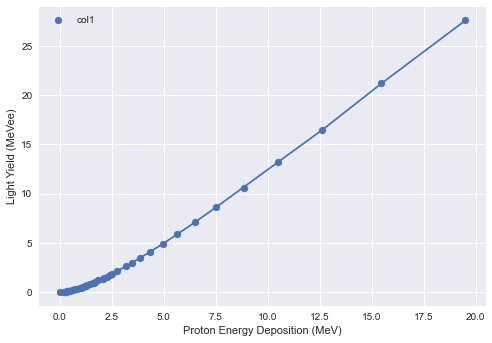

In [969]:
plt.scatter(x, y, label="col1")

def f(x, A, B, C, D, E, F, G):
    return A*x + B*x**2 + C*x**3 + D*x**4 + E*x**5 + F*x**6 + G*x**7

popt, pcov = optimize.curve_fit(f, x, y)

plt.plot(x, f(x, *popt))

plt.xlabel("Proton Energy Deposition (MeV)")
plt.ylabel("Light Yield (MeVee)")
plt.legend()

pRF = lambda x : f(x, *popt)

In [738]:
IDtoLightYield = {}
for ID in ptclTree:
    lightYield = ptclLightYield(ptclTree[ID], pRF)
    if lightYield > 0.0:
        IDtoLightYield[ID] = lightYield
lightYield = IDtoLightYield.values()

In [ ]:
def GetLightYield(data):
    
    ptclTree = buildPtclTree("../EJ309-build/data/" + data)
    
    IDtoLightYield = []
    for ID in ptclTree:
        lightYield = ptclLightYield(ptclTree[ID], pRF)
        if lightYield > 0.0:
            IDtoLightYield.append(lightYield)
            
    return np.array(IDtoLightYield)


In [704]:
dataToLightYield = { }

for filename in os.listdir("../EJ309-build/data/"):
    if filename.endswith(".csv"):
        dataToLightYield[filename] = GetLightYield(filename)

In [721]:
for key in dataToLightYield:

    value = dataToLightYield[key]

    i = key.find("_")
    ptcl = key[0:i]
    key = key[i + 1:]

    i = key.find("_")
    energy = key[0:i]
    key = key[i + 1:]

    i = key.find(".")
    unit = key[0:i]

    ptcl, energy, unit

    try:
        os.mkdir("LightOutput/"+particle+energy+unit)
    except:
        pass

    bins = plt.hist(value, bins = 60, density = True)
    plt.xlabel("Light Output (a.u.)")
    plt.ylabel("probability density")
    plt.title("Scintillator Light Yield from " 
               + energy + " " + unit + " " + ptcl)
    
    plt.ylim( 0, max(bins[0]) )
    plt.xlim( 0, max(bins[1]) * 1.2 )
    plt.savefig("LightOutput/"+particle+energy+unit+"/lightRF.png")
    
    plt.clf()

<Figure size 576x396 with 0 Axes>

In [740]:
ptclTree["2-100"]["children"]

{'2-103': {'allEvents': [array(['2-103', '2-100', 'C12', 1998.68638, 'ej309', 1998.68638, 9.222242],
         dtype=object),
   array(['2-103', '2-100', 'C12', 0.0, 'ej309', 0.0, 9.222271000000001],
         dtype=object)],
  'children': {},
  'totalEDep': -1},
 '2-102': {'allEvents': [array(['2-102', '2-100', 'proton', 261361.31065300002, 'ej309',
          261361.31065300002, 7.8749460000000004], dtype=object)],
  'children': {},
  'totalEDep': -1},
 '2-101': {'allEvents': [array(['2-101', '2-100', 'proton', 2104860.229371, 'ej309',
          2168832.9977169996, 3.5765620000000005], dtype=object),
   array(['2-101', '2-100', 'proton', 45485.419351, 'ej309',
          63972.768346000004, 3.5807300000000004], dtype=object),
   array(['2-101', '2-100', 'proton', 15966.812033000002, 'ej309',
          18487.348995, 3.5810419999999996], dtype=object),
   array(['2-101', '2-100', 'proton', 2520.536962, 'ej309', 2520.536962,
          3.5813260000000002], dtype=object)],
  'children': {},
 

In [1028]:
ptcl = "neutron"
energy = "2.45"
unit = "MeV"

ptclTree = buildPtclTree("../EJ309-build/data/"+ptcl+"_"+energy+"_"+unit+".csv")

In [934]:
len(ptclTree.keys())

2348225

In [1029]:
# Separate the data into categories : 
# single np , nCp, double np, triple np, other

scatterTypes = { "single_np" : [] , "nCp" : [] , "double_np" : [] ,
                 "triple_np" : [] , "other" : [] }

for ptcl in ptclTree.values() :
    # Put children in list
    children = list(ptcl["children"].values())
    # Sort by time of creation of child
    children.sort(key = lambda x : x["allEvents"][0][6])
    
    if len(children) == 1 and children[0]["allEvents"][0][2] in "proton":
        scatterTypes["single_np"].append(ptcl)
    elif len(children) > 1 and children[0]["allEvents"][0][2] in "proton" and children[1]["allEvents"][0][2] not in "proton":
        scatterTypes["single_np"].append(ptcl)
        
    elif len(children) == 2 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:2] ]):
        scatterTypes["double_np"].append(ptcl)
    elif len(children) > 2 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:2] ]) and children[2]["allEvents"][0][2] not in "proton":
        scatterTypes["double_np"].append(ptcl)
        
    elif len(children) == 3 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:3] ]):
        scatterTypes["triple_np"].append(ptcl)
    elif len(children) > 3 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:3] ]) and children[3]["allEvents"][0][2] not in "proton":
        scatterTypes["triple_np"].append(ptcl)
    
    elif len(children) == 2 and children[0]["allEvents"][0][2] in "proton" and children[1]["allEvents"][0][2] in "C12 C13":
        scatterTypes["nCp"].append(ptcl)
    elif len(children) == 2 and children[1]["allEvents"][0][2] in "proton" and children[0]["allEvents"][0][2] in "C12 C13":
        scatterTypes["nCp"].append(ptcl)
        
    else:
        scatterTypes["other"].append(ptcl)
    

In [1030]:
singleNP = np.array([ptclLightYield(ptcl, pRF) for ptcl in scatterTypes["single_np"]])
doubleNP = np.array([ptclLightYield(ptcl, pRF) for ptcl in scatterTypes["double_np"]])
tripleNP = np.array([ptclLightYield(ptcl, pRF) for ptcl in scatterTypes["triple_np"]])
nCp = np.array([ptclLightYield(ptcl, pRF) for ptcl in scatterTypes["nCp"]])
other = np.array([ptclLightYield(ptcl, pRF) for ptcl in scatterTypes["other"]])
total = np.concatenate((singleNP,doubleNP,tripleNP,nCp,other))

In [1031]:
np.mean(other)

0.02597164023364574

Text(0, 0.5, 'counts')

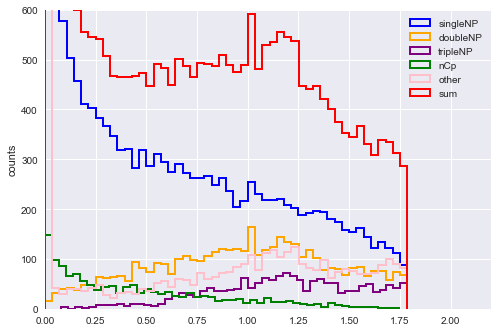

In [1039]:
data = singleNP
colors = "blue"
labels = 'singleNP'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 50, linewidth = 2)

data = doubleNP
colors = "orange"
labels = 'doubleNP'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 50, linewidth = 2)

data = tripleNP
colors = "purple"
labels = 'tripleNP'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 50, linewidth = 2)

data = nCp
colors = "green"
labels = 'nCp'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 50, linewidth = 2)

data = other
colors = "pink"
labels = 'other'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 50, linewidth = 2)

plt.hist(total, histtype = "step", bins = 50, linewidth = 2, label="sum", color="red")

plt.legend()
plt.xlim(0,2.2)
plt.ylim(0,600)
plt.ylabel("counts")

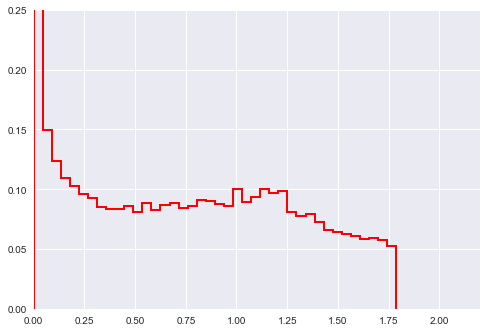

In [1034]:
plt.hist(total, histtype = "step", bins = 40, linewidth = 2, label="sum", color="red", density = True)
plt.ylim(0,0.25)
plt.xlim(0,2.2)
None